In [ ]:
# https://github.com/tensorflow/magenta/blob/01b59d352dd2928fb94630b751d2c8e893c8701c/magenta/models/nsynth/baseline/models/ae.py

In [9]:
%load_ext autoreload
%autoreload 2

In [ ]:
"""
### TO INITIALLY DOWNLOAD THE DATASET
# Construct a tf.data.Dataset
ds_train, ds_test = tfds.load(
    name="nsynth", split=["train", "test"], data_dir= DATA_DIR / "tensorflow_datasets"
)"""

In [303]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
from avgn.utils.paths import DATA_DIR
from avgn.magenta.nsynthreader import NSynthDataset

In [5]:
dataset = NSynthDataset(tfrecord_path = DATA_DIR / "tensorflow_datasets")

In [6]:
class HParams(object):
    """ Hparams was removed from tf 2.0 so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
hparams = HParams(
    batch_size = 8, 
    n_fft=1024,
    fw_loss_coeff=10.0,
    fw_loss_cutoff=4000,
    num_latent=1984,
    log_mag=True,
    hop_length=256,
    mask=True,
    re_im=False,
    dphase=True,
    mag_only=True,
    pad=True,
)

In [11]:
from avgn.magenta.nsynthutils import tf_specgram
import numpy as np

In [19]:
list((DATA_DIR / "tensorflow_datasets").glob('*.tfrecord'))

[]

In [24]:
training_tfrecords = list((DATA_DIR / "tensorflow_datasets"/"nsynth").glob('**/*train.tfrecord*'))

##### take a look at the data

In [66]:
raw_dataset = tf.data.TFRecordDataset([str(training_tfrecords[0])])

In [67]:
dset = raw_dataset.take(count=10)
# grab a single element from that dataset
element = list(dset)[1]
# a "Feature message" https://www.tensorflow.org/api_docs/python/tf/train/Example
example = tf.train.Example()
# parse the element in to the example message
example.ParseFromString(element.numpy())
list(example.features.feature)

['qualities/dark',
 'instrument/family',
 'qualities/fast_decay',
 'qualities/distortion',
 'instrument/label',
 'velocity',
 'qualities/multiphonic',
 'qualities/long_release',
 'instrument/source',
 'qualities/nonlinear_env',
 'pitch',
 'qualities/tempo-synced',
 'qualities/reverb',
 'qualities/bright',
 'id',
 'audio',
 'qualities/percussive']

In [45]:
from avgn.magenta.nsynthutils import tf_specgram

In [224]:
# https://github.com/keithito/tacotron/blob/master/util/audio.py
def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)


def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _db_to_amp_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals, hparams.win_length, hparams.hop_length, hparams.n_fft, pad_end=False
    )

In [225]:
if int(tf.__version__[0]) < 2:
    from tensorflow import FixedLenFeature, parse_single_example
else:
    from tensorflow.io import FixedLenFeature, parse_single_example

class NSynthDataset(object):
    def __init__(self, tf_records, hparams, is_training=True):
        self.is_training = is_training
        self.hparams = hparams
        # create dataset of tfrecords
        self.raw_dataset = tf.data.TFRecordDataset(tf_records)
        # prepare dataset iterations
        self.dataset = self.raw_dataset.map(lambda x: self._parse_function(x))
        self.dataset.batch(hparams.batch_size)

    def prepare_example(self, example):
        audio = tf.slice(example["audio"], [0], [64000])
        audio = tf.reshape(audio, [1, 64000])
        pitch = tf.slice(example["pitch"], [0], [1])
        velocity = tf.slice(example["velocity"], [0], [1])

        audio = spectrogram_tensorflow(example['audio'], self.hparams)
        
        return {
            'audio': audio,
            'pitch': pitch,
            'velocity': velocity,
            'specgram': specgram
               }

    def _parse_function(self, example_proto):
        features = {
            # "note_str": FixedLenFeature([], dtype=tf.string),
            "pitch": FixedLenFeature([1], dtype=tf.int64),
            "velocity": FixedLenFeature([1], dtype=tf.int64),
            "audio": FixedLenFeature([64000], dtype=tf.float32),
            # "qualities": FixedLenFeature([10], dtype=tf.int64),
            # "instrument_source": FixedLenFeature([1], dtype=tf.int64),
            # "instrument_family": FixedLenFeature([1], dtype=tf.int64),
        }
        example = parse_single_example(example_proto, features)        
        #example = self.prepare_example(example)
        return example

In [295]:
hparams = HParams(  
    batch_size = 32,
    win_length = 512,
    n_fft = 1024,
    hop_length=256,
    ref_level_db = 20,
    min_level_db = -100,
    power = 1, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
)

In [296]:
dset = NSynthDataset([str(i) for i in training_tfrecords], hparams)

In [297]:
from avgn.magenta.nsynthutils import specgram

In [298]:
ex = next(iter(dset.dataset))

In [299]:
ex

{'audio': <tf.Tensor: id=4907, shape=(64000,), dtype=float32, numpy=
 array([ 3.0186407e-06, -3.1179025e-06,  3.0848969e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>,
 'pitch': <tf.Tensor: id=4908, shape=(1,), dtype=int64, numpy=array([56])>,
 'velocity': <tf.Tensor: id=4909, shape=(1,), dtype=int64, numpy=array([25])>}

In [300]:
spec = spectrogram_tensorflow(ex['audio'], hparams).numpy()

In [301]:
import matplotlib.pyplot as plt
%matplotlib inline

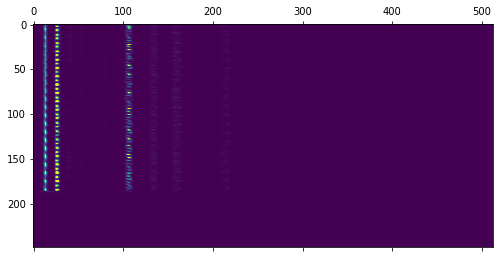

In [302]:
plt.matshow(spec)

In [234]:
import IPython

In [235]:
IPython.display.Audio(data=ex['audio'].numpy(), rate=16000)

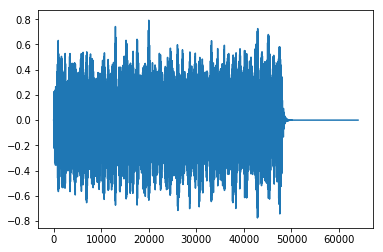

In [236]:
plt.plot(ex['audio'].numpy())

In [242]:
spec = spectrogram_tensorflow(ex['audio'], hparams)
spec

<tf.Tensor: id=4461, shape=(249, 513), dtype=float32, numpy=
array([[0.8100153 , 0.8100134 , 0.81006074, ..., 0.81000036, 0.8100003 ,
        0.8100003 ],
       [0.8100047 , 0.8100507 , 0.8100543 , ..., 0.8100003 , 0.8100005 ,
        0.81000054],
       [0.8100223 , 0.81001437, 0.81001467, ..., 0.8100002 , 0.81000006,
        0.81000006],
       ...,
       [0.81      , 0.81      , 0.81      , ..., 0.81      , 0.81      ,
        0.81      ],
       [0.81      , 0.81      , 0.81      , ..., 0.81      , 0.81      ,
        0.81      ],
       [0.81      , 0.81      , 0.81      , ..., 0.81      , 0.81      ,
        0.81      ]], dtype=float32)>

2.0.0-alpha0


2.0.0-alpha0


AttributeError: 'int' object has no attribute 'value'

In [263]:
%debug

> /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/spectral_ops.py(275)inverse_stft()
    273       window = window_fn(frame_length, dtype=stfts.dtype.real_dtype)
    274       real_frames *= window
--> 275     return reconstruction_ops.overlap_and_add(real_frames, frame_step)
    276 
    277 

ipdb> real_frames.shape[-1]
512
ipdb> real_frames.shape
TensorShape([2, 512])
ipdb> type(real_frames.shape[-1])
<class 'int'>
--KeyboardInterrupt--
ipdb> exit


AttributeError: 'int' object has no attribute 'value'

In [253]:
??tf.signal.inverse_stft

In [243]:
def _istft_tensorflow(stfts, hparams):
    return tf.signal.inverse_stft(
        stfts, hparams.win_length, hparams.hop_length, hparams.n_fft
    )

def _griffin_lim_tensorflow(S, hparams):
    """TensorFlow implementation of Griffin-Lim
  Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
  and https://github.com/keithito/tacotron/blob/master/util/audio.py
  """
    # TensorFlow's stft and istft operate on a batch of spectrograms; 
    # create batch of size 1
    S = tf.expand_dims(S, 0)
    S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
    print(S_complex)
    y = _istft_tensorflow(S_complex, hparams)
    for i in range(hparams.griffin_lim_iters):
        est = _stft_tensorflow(y)
        angles = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64)
        y = _istft_tensorflow(S_complex * angles)
    return tf.squeeze(y, 0)

In [284]:
import librosa 

def _stft(y, hparams):
  return librosa.stft(y=y, n_fft=hparams.n_fft, hop_length=hparams.hop_length, win_length=hparams.win_length)


def _istft(y, hparams):
  return librosa.istft(y, hop_length=hparams.hop_length, win_length=hparams.win_length)

def _griffin_lim(S, hparams):
  '''librosa implementation of Griffin-Lim
  Based on https://github.com/librosa/librosa/issues/434
  '''
  angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
  S_complex = np.abs(S).astype(np.complex)
  y = _istft(S_complex * angles, hparams)
  for i in range(hparams.griffin_lim_iters):
    angles = np.exp(1j * np.angle(_stft(y, hparams)))
    y = _istft(S_complex * angles, hparams)
  return y

def _db_to_amp(x):
  return np.power(10.0, x * 0.05)

def _denormalize(S, hparams):
  return (np.clip(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db

def inv_spectrogram(spectrogram, hparams):
  '''Converts spectrogram to waveform using librosa'''
  S = _db_to_amp(_denormalize(spectrogram, hparams) + hparams.ref_level_db)  # Convert back to linear
  return _griffin_lim(S ** hparams.power, hparams)          # Reconstruct phase

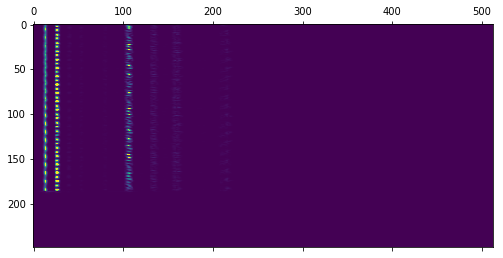

In [290]:
plt.matshow(spec.numpy())

In [292]:
hparams = HParams(  
    batch_size = 32,
    win_length = 512,
    n_fft = 1024,
    hop_length=256,
    ref_level_db = 20,
    min_level_db = -100,
    power = 2, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
)

In [293]:
reconstructed_y = inv_spectrogram(spec.numpy().T, hparams)

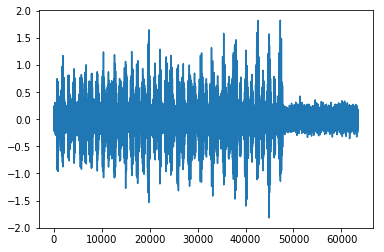

In [294]:
plt.plot(reconstructed_y)

In [291]:
IPython.display.Audio(data=reconstructed_y, rate=16000)